In [28]:
from langchain_core.messages import BaseMessage,AIMessage, SystemMessage
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_experimental.text_splitter import SemanticChunker
from langgraph.graph.message import add_messages
import asyncio
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.types import Command
from typing import Annotated, Literal, TypedDict, Sequence, List
from pydantic import BaseModel,Field
from operator import itemgetter
import os
from dotenv import load_dotenv
load_dotenv()
tavily_tool = TavilySearchResults(search_depth='advanced',max_results=5)
search=[tavily_tool]

In [39]:
llm = ChatOpenAI(model="gpt-4.1-nano-2025-04-14")
llm = llm.bind_tools(tools=search)
embedder = OpenAIEmbeddings()

In [40]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    file_path: str
    documents: List[Document]
    retriever: BaseRetriever
    search_performed: bool
    rag_used: bool 

class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

class RouterDecision(BaseModel):
    next_step: Literal["rag", "search", "general_chat"] = Field(
        description="Pick 'rag' for doc info, 'search' for web info, 'chatbot' for general medical knowledge, or 'out_of_scope' for non-medical topics."
    )

structured_llm_grader = llm.with_structured_output(GradeDocuments)
router_llm = llm.with_structured_output(RouterDecision)

def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

In [41]:
def retrieve(state: AgentState)-> Command[Literal['router']]:
    
    file_path = state['file_path']
    if file_path != '':
        if not os.path.exists(file_path):
            return {"messages": [AIMessage(content="File not found.")]}
        
        loader = PyPDFLoader(file_path)
        docs =  loader.load()
        
        
        text_splitter =  SemanticChunker(
            embedder, 
            breakpoint_threshold_type="standard_deviation",
            breakpoint_threshold_amount=1.5
        )
        
        splits = text_splitter.split_documents(docs)
        
        vectorstore = Chroma.from_documents(
            documents=splits, 
            embedding=embedder
        )
        
        retriever = vectorstore.as_retriever()
    
        return Command(goto='router', update={'retriever':retriever,'documents': docs})
    
    else: return Command(goto='router', update={'retriever':'','documents': ''})

In [42]:
async def supervisor_router(state: AgentState) -> Command[Literal['RAG', 'search_tool', 'LLM', END]]:
    question = state["messages"][-1].content
    has_searched = state.get("search_performed", False)
    rag_done = state.get('rag_used', False)
    
    # We provide the LLM with a hint about what we have
    prompt = f"""You are a Medical Gatekeeper Orchestrator. 
    User Question: {question}
    Files Available: {'Yes' if state.get('file_path') else 'No'}
    Search Already Used: {'Yes' if has_searched else 'No'}
    Checked Medical PDFs: {'Yes' if rag_done else 'No'}
    
    CRITICAL RULES:
    1. Evaluate if the question is related to medicine, health, biology, or clinical data.
    2. If the question is NOT medical, return 'out_of_scope'.
    3. If medical:
        - Use 'rag' if the answer is likely in the uploaded medical PDF.
        - Use 'search' ONLY if 'Search Already Used' is 'No'.
        - Use 'chatbot' if search has already been used or for general advice.
    """
    
    decision = await router_llm.ainvoke(prompt)
    if decision.next_step == "out_of_scope":
        refusal = AIMessage(content="I am a specialized medical assistant. I cannot answer non-medical questions.")
        return Command(goto=END, update={"messages": [refusal]})
    elif decision.next_step == "rag":
        if rag_done:
             return Command(goto='LLM')
        return Command(goto='RAG', update={'rag_used': True})
    elif decision.next_step == "search":
        if has_searched:
             return Command(goto='LLM')
        
        msg = await llm.ainvoke(state["messages"])
        return Command(goto='search_tool', update={'messages': [msg], 'search_performed': True})
    else:
        return Command(goto='LLM')

In [43]:
async def process_uploaded_file(state:AgentState) -> Command[Literal['router']]:
    """Process uploaded files for suitable output"""
    
    file_path = state['file_path']
    retriever = state['retriever']
    
    if os.path.exists(file_path):
        
        template = """Answer based strictly on the context below:
        {context}

        Question: {question}
        """
        prompt = ChatPromptTemplate.from_template(template)
        
        
        rag_chain = (
            # Take the input dictionary and ADD a 'context' key to it
            RunnablePassthrough.assign(
                context=itemgetter("question") | retriever | format_docs
            )
            | prompt
            | llm
            | StrOutputParser()
        )
        query_dictionary = state['messages'][-1].content
        result = await rag_chain.ainvoke({'question':query_dictionary})
        
        return Command(goto='router', update={'messages': result})
        
    else:
        return Command(goto=END, update={"messages": [AIMessage(content="Please check the file you uploaded exists and isn't corrupted.")]})

In [44]:
async def chatbot(state: AgentState)->Command[Literal[END]]:
    sys_msg = SystemMessage(content=(
        "You are a respectful medical agent. Answer ONLY medical questions. "
        "Do not hallucinate. If you are unsure, say so. "
        "You have tools (Search/RAG) at your disposal via the router, "
        "so only provide direct answers if you are certain of your training data."
    ))
    messages = [sys_msg] + state["messages"]
    response = await llm.ainvoke(messages)
    return Command(goto=END, update={"messages": [response]})

In [45]:
graph = StateGraph(AgentState)
graph.add_node('router', supervisor_router)
graph.add_node('RAG', process_uploaded_file)
graph.add_node('LLM', chatbot)
graph.add_node('retriever',retrieve)
graph.add_node('search_tool', ToolNode(search))
graph.set_entry_point('retriever')
graph.add_edge('search_tool','router')

app = graph.compile()

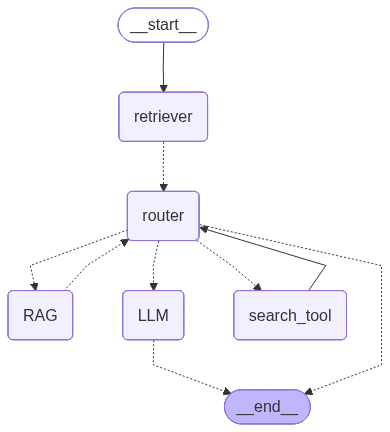

In [46]:
app

In [48]:
await app.ainvoke({'messages':'whats the latest news in medical science','documents':[],'file_path':r""})

{'messages': [HumanMessage(content='whats the latest news in medical science', additional_kwargs={}, response_metadata={}, id='f6555b2d-bfac-4800-9779-0e15f42c6164'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 87, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_b6501e8a2c', 'id': 'chatcmpl-D4EWNeas3MQlANlU4XlIzEq23ofQc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c1659-af0b-7a02-8714-6b7af330c9f1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest news in medical science'}, 'id': 'call_85NaCLFm7ZdkSwFybpjL8v3J', 'type': 'tool_call'}], usage_metada